In [10]:
#!pip install -r requirements.txt

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import networkx as nx
import pickle


from tqdm import trange
from numpy.random import default_rng

from dag_gflownet.env import GFlowNetDAGEnv
from dag_gflownet.gflownet import DAGGFlowNet
from dag_gflownet.utils.replay_buffer import ReplayBuffer
from dag_gflownet.utils.factories import get_scorer
from dag_gflownet.utils.gflownet import posterior_estimate
from dag_gflownet.utils.metrics import expected_shd, expected_edges, threshold_metrics
from dag_gflownet.utils import io

/Users/sjleslie/miniconda-jan3/envs/dag_gflownet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt


# Utilities
Function main() is taken from train.py. 
Class Args is to get around the use of argparser in the original code and streamline the number of arguments

In [3]:
#from train.py
#edited to allow for no ground truth
def main(args):
    rng = default_rng(args.seed)
    key = jax.random.PRNGKey(args.seed)
    key, subkey = jax.random.split(key)

    # Create the environment
    scorer, data, graph = get_scorer(args, rng=rng)
    env = GFlowNetDAGEnv(
        num_envs=args.num_envs,
        scorer=scorer,
        num_workers=args.num_workers,
        context=args.mp_context
    )

    # Create the replay buffer
    replay = ReplayBuffer(
        args.replay_capacity,
        num_variables=env.num_variables
    )

    # Create the GFlowNet & initialize parameters
    gflownet = DAGGFlowNet(
        delta=args.delta,
        update_target_every=args.update_target_every
    )
    optimizer = optax.adam(args.lr)
    params, state = gflownet.init(
        subkey,
        optimizer,
        replay.dummy['adjacency'],
        replay.dummy['mask']
    )
    exploration_schedule = jax.jit(optax.linear_schedule(
        init_value=jnp.array(0.),
        end_value=jnp.array(1. - args.min_exploration),
        transition_steps=args.num_iterations // 2,
        transition_begin=args.prefill,
    ))

    # Training loop
    indices = None
    observations = env.reset()
    with trange(args.prefill + args.num_iterations, desc='Training') as pbar:
        for iteration in pbar:
            # Sample actions, execute them, and save transitions in the replay buffer
            epsilon = exploration_schedule(iteration)
            actions, key, logs = gflownet.act(params.online, key, observations, epsilon)
            
            next_observations, delta_scores, dones, _ = env.step(np.asarray(actions))
            indices = replay.add(
                observations,
                actions,
                logs['is_exploration'],
                next_observations,
                delta_scores,
                dones,
                prev_indices=indices
            )
            observations = next_observations

            if iteration >= args.prefill:
                # Update the parameters of the GFlowNet
                samples = replay.sample(batch_size=args.batch_size, rng=rng)
                params, state, logs = gflownet.step(params, state, samples)


                pbar.set_postfix(loss=f"{logs['loss']:.2f}", epsilon=f"{epsilon:.2f}")

    # Evaluate the posterior estimate
    posterior, _ = posterior_estimate(
        gflownet,
        params.online,
        env,
        key,
        num_samples=args.num_samples_posterior,
        desc='Sampling from posterior'
    )

    # Compute the metrics
    if graph is not None:
        ground_truth = nx.to_numpy_array(graph, weight=None)
        results = {
            'expected_shd': expected_shd(posterior, ground_truth),
            'expected_edges': expected_edges(posterior),
            **threshold_metrics(posterior, ground_truth)
        }
    else:
        results = "No ground truth provided."        

    # Save model, data & results
    args.output_folder.mkdir(exist_ok=True)
    with open(args.output_folder / 'arguments.json', 'w') as f:
        json.dump(vars(args), f, default=str)
    data.to_csv(args.output_folder / 'data.csv')
    with open(args.output_folder / 'graph.pkl', 'wb') as f:
        pickle.dump(graph, f)
    io.save(args.output_folder / 'model.npz', params=params.online)
    replay.save(args.output_folder / 'replay_buffer.npz')
    np.save(args.output_folder / 'posterior.npy', posterior)
    with open(args.output_folder / 'results.json', 'w') as f:
        json.dump(results, f, default=list)
    
    #added
    print(results)
    


In [4]:
#A hack to get around the fact they used ArgParser without having to modify every function ...
class Args:
     
      def __init__(self, graph, model=None, samples=None, num_variables=5, num_edges=5,
                   num_samples=100, score="bde", num_envs=8, scorer_kwargs={}, prior="uniform", prior_kwargs={},
                   lr=1e-5,delta=1., batch_size=32, num_iterations=100000, replay_capacity=100000,
                   prefill=1000,min_exploration=0.1, update_epsilon_every=10, num_samples_posterior=1000,
                   update_target_every=1000, seed=0, num_workers=4, mp_context="spawn",
                   output_folder="output"):
          
          self.graph=graph
          self.model=model
          self.samples=samples
          self.num_variables = num_variables
          self.num_edges = num_edges
          self.num_samples = num_samples
          self.score = score
          self.num_envs = num_envs
          self.scorer_kwargs = scorer_kwargs
          self.prior = prior
          self.prior_kwargs = prior_kwargs
          self.lr = lr
          self.delta = delta
          self.batch_size = batch_size
          self.num_iterations = num_iterations
          self.replay_capacity = replay_capacity
          self.prefill = prefill
          self.min_exploration = min_exploration
          self.update_epsilon_every = update_epsilon_every
          self.num_samples_posterior = num_samples_posterior
          self.update_target_every = update_target_every
          self.seed = seed
          self.num_workers = num_workers
          self.mp_context = mp_context
          self.output_folder = Path(output_folder)


### A simplified call to a train a GFlowNet
A lot of functionality is masked for simplicity; see Args class above

In [5]:
def train_gflownet(graph="custom", model=None, samples=None, score="bde", prior="uniform", prior_kwargs={},
                   batch_size=32, num_iterations=10000, 
                   output_folder="output"):
    
    args = Args(graph=graph, model=model, samples=samples, score=score, prior=prior, prior_kwargs=prior_kwargs, batch_size=batch_size, num_iterations=num_iterations,
                   output_folder=output_folder)
    main(args)

### Generate samples from a discrete Bayesian network

In [6]:
#cut and pasted, then slightly modified, from sample.py
def sample_from_discrete(model, num_samples):
    """Sample from a discrete model using ancestral sampling."""
    if not isinstance(model, BayesianNetwork):
        raise ValueError('The model must be an instance of BayesianNetwork')
    sampler = BayesianModelSampling(model)
    samples = sampler.forward_sample(size=num_samples, show_progress=False)

    # Convert values to pd.Categorical for faster operations
    for node in samples.columns:
        cpd = model.get_cpds(node)
        samples[node] = pd.Categorical(samples[node], categories=cpd.state_names[node])

    return samples

### Get the posterior in a nice form

In [7]:
def process_posterior(path, node_names):
    posterior = np.load(path)
    dags, count = np.unique(posterior, axis=0, return_counts=True)
    dags = dags[np.argsort(count)][::-1]
    count = np.sort(count)[::-1]

    graphs = []
    for i in range(dags.shape[0]):
        graph = nx.from_numpy_array(dags[i], create_using=nx.DiGraph)
        nx.relabel_nodes(graph, {i:label for i, label in enumerate(node_names)},copy=False)
        graphs.append(graph)
    
    return dags, count, graphs

### Graph the DAGs returned in the posterior

In [8]:
def graph_posterior(graphs, count, max_num=10):

    #check this line
    max_num = np.min([max_num,len(graphs)])

    for i in range(max_num):
        nx.draw_networkx(graphs[i])
        print(f"probability of graph: {count[i]/1000}")
        plt.show()
        print("\n")
        print("\n")

## Now we can define a model using pgmpy and train on it pretty easily!

In [9]:
#R: Raining, S: Sprinker on, G: Grass wet. 0=no, 1=yes
#G=0: grass is not wet; G=1: grass is wet
model = BayesianNetwork([("R","S"),("S","G"),("R","G")])
cpd_R = TabularCPD(variable="R", variable_card=2, values=[[0.8],[0.2]])
cpd_S = TabularCPD(variable="S", variable_card=2, values=[[0.2,0.9],[0.8,0.1]], evidence=["R"], evidence_card=[2])
cpd_G = TabularCPD(variable="G", variable_card=2, values=[[0.99,0.1,0.2,0.01],[0.01,0.9,0.8,0.99]], evidence=["R", "S"], evidence_card=[2,2])
model.add_cpds(cpd_R, cpd_S, cpd_G)

/var/folders/k8/n_2s8vh107ndn49xgmw8zhvh0000gn/T/ipykernel_59282/2207347324.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  cpd_S = TabularCPD(variable="S", variable_card=2, values=[[0.2,0.9],[0.8,0.1]], evidence=["R"], evidence_card=[2])
/var/folders/k8/n_2s8vh107ndn49xgmw8zhvh0000gn/T/ipykernel_59282/2207347324.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  cpd_G = TabularCPD(variable="G", variable_card=2, values=[[0.99,0.1,0.2,0.01],[0.01,0.9,0.8,0.99]], evidence=["R", "S"], evidence_card=[2,2])


In [10]:
samples = sample_from_discrete(model,100)

## Now we define our prior. 

It should be an array of size (num_variables, num_variables). If the prior for a variable i causing a variable j is low, then arr[i,j] should be a moderately large negative number. If we are uncertain whether i causes j, then 0 is a good choice. 

I say moderate because very large negative numbers that swamp the likelihood part of the reward seemed to make it hard for the GFlowNet to train. 

In principle, we should be able to have a positive number in the array if our prior was high that i causes j, but I didn't test that.

In [11]:
logits_array = np.array([[0,0,0],[-1e2,0,0],[-1e2,-1e2,0]])

## Train our model with a custom prior

To use this, we set prior="custom_adj" and pass in our logits_array as an entry in prior_kwargs.

In [12]:
train_gflownet(model=model,samples=samples, num_iterations=10000, prior="custom_adj", prior_kwargs={"logits_array": logits_array}, output_folder="tests/test")

Sampling from posterior: 100%|██████████| 1000/1000 [00:05<00:00, 182.39it/s]


{'expected_shd': 0.0, 'expected_edges': 3.0, 'fpr': array([0., 0., 1.]), 'tpr': array([0., 1., 1.]), 'roc_auc': 1.0, 'precision': array([0.33333333, 1.        , 1.        ]), 'recall': array([1., 1., 0.]), 'prc_auc': 1.0, 'ave_prec': 1.0}


# Inspect the posterior

In [13]:
dags, count, graphs = process_posterior("tests/test/posterior.npy",node_names=["R","S","G"])

In [14]:
dags

array([[[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]]])

In [15]:
count

array([1000])

probability of graph: 1.0


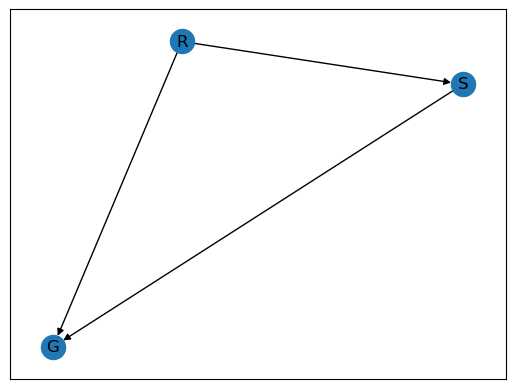

In [16]:
graph_posterior(graphs,count)

The prior seemed to work and faciliated recovering the ground truth in this simple example! Yay!

### Inspecting scores

In [24]:
from dag_gflownet.scores.bde_score import BDeScore

In [27]:
args = Args(model=model, graph="custom", samples=samples, num_iterations=10000, prior="custom_adj", prior_kwargs={"logits_array": logits_array}, output_folder="tests/test")
scorer, _, _ = get_scorer(args)

Use scorer.get_local_scores to compute the *difference* in scores as a result of adding an edge to the graph. In particular, we pass in as the first argument the index of the target node (thing being caused), and its previous set of parents before adding the new edge as the second argument. The third argument is the set of parents after we add the new edge. 

In [29]:
#Get the scores for first an edge from R (0) to S (1) 
#then for adding to that an edge from G (2) to S (1)

scorer.get_local_scores(1, (0,), (0,2))

(LocalScore(key=(1, (0,)), score=-43.34350580642707, prior=0.0),
 LocalScore(key=(1, (0, 2)), score=-25.58155115861723, prior=-100.0))

In [30]:
#explicitly compute the delta in scores from adding the new edge
score_before, score_after = scorer.get_local_scores(1, (0,), (0,2))

delta_score = score_after.score + score_after.prior - (score_before.score + score_before.prior)
delta_score

-82.23804535219017

Notice that this gives us the *delta* from adding the edge. It does not give us the score for the whole graph, because we didn't provide the necessary information for that, since get_local_scores only considers a single target, whereas a full graph probably has multiple target nodes. 

If a node previously had no edges coming to it, we can pass in a set of empty indices:

In [32]:
#Adding an edge from R (0) to S (1) where S previously had no parents
scorer.get_local_scores(1, (), (0,))

(LocalScore(key=(1, ()), score=-59.83706697228068, prior=0.0),
 LocalScore(key=(1, (0,)), score=-43.34350580642707, prior=0.0))


# NB: Below this point are old examples, with no customization of the prior. 

Some/all of it may be worth revisiting, so I kept it -- but it has NOT been updated.

## See if DAG-GFlowNet can learn independence of nodes from small sample

In [44]:
def format_samples(df,categories=[0,1]):
    for node in df.columns:
        df[node] = pd.Categorical(df[node], categories=categories)
    return df

In [40]:
#Create small set of samples reflecting independence of R and S
independent = pd.DataFrame(np.array([[1,1],[0,1],[1,0],[0,0]]), columns=['R', 'S'])

#Get it in the right format
for node in independent.columns:
    independent[node] = pd.Categorical(independent[node], categories=[0,1])

independent

,R,S
0,1,1
1,0,1
2,1,0
3,0,0


In [41]:
print(BDeuScore(independent).score(BayesianNetwork([("R","S")])))
print(BDeuScore(independent).score(BayesianNetwork([("S","R")])))
no_edges = BayesianNetwork()
no_edges.add_nodes_from(["R","S"])
print(BDeuScore(independent).score(no_edges))

-6.085173445545335
-6.085173445545335
-5.89588321943528


In [42]:
train_gflownet(model=None,samples=independent, num_iterations=2000,output_folder="tests/test3")

Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 811.59it/s]

No ground truth provided.


### Not terrible!

probability of graph: 0.625


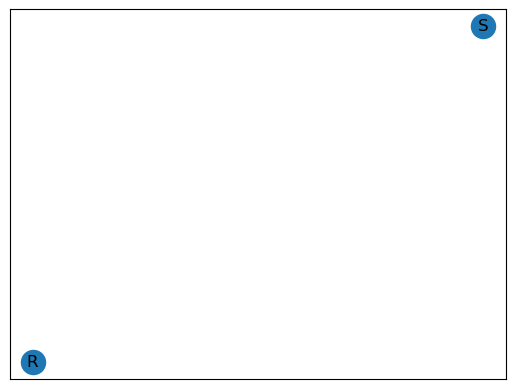





probability of graph: 0.203


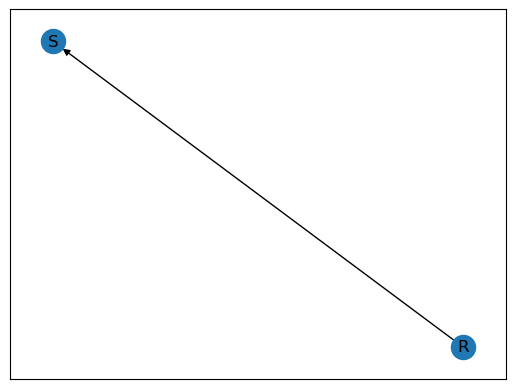





probability of graph: 0.172


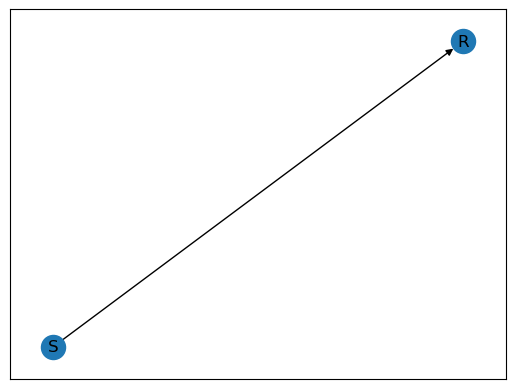

In [56]:
dags, count, graphs = process_posterior("tests/test3/posterior.npy",node_names=["R","S"])
graph_posterior(graphs,count)

## Ignore

Backwards Blocking Blickets -- makes no sense with uniform prior. Will revisit when I customize priors; see below.

In [48]:
blickets = pd.DataFrame(np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[1,1,1],[1,0,1]]), columns=['Object1', 'Object2', 'Machine'])
blickets = format_samples(blickets)
blickets

,Object1,Object2,Machine
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,1,1
5,1,0,1


In [49]:
train_gflownet(model=None,samples=blickets, num_iterations=5000,output_folder="test4")

Sampling from posterior: 100%|██████████| 1000/1000 [00:04<00:00, 223.36it/s]

No ground truth provided.


probability of graph: 0.092


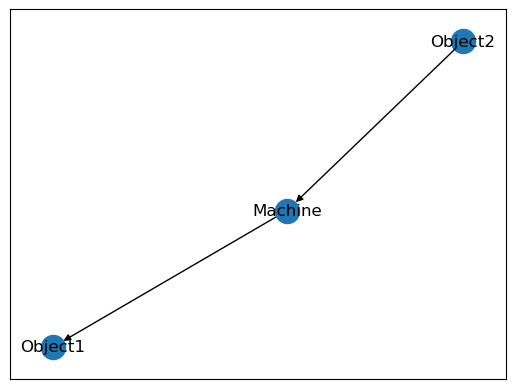





probability of graph: 0.087


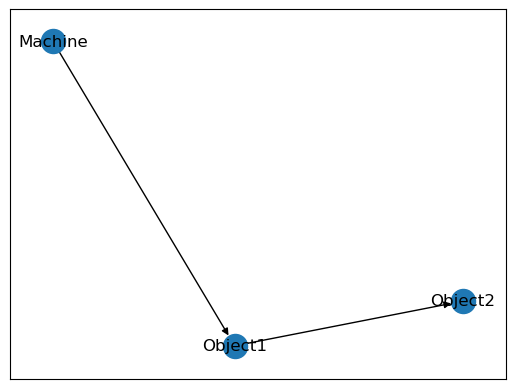





probability of graph: 0.084


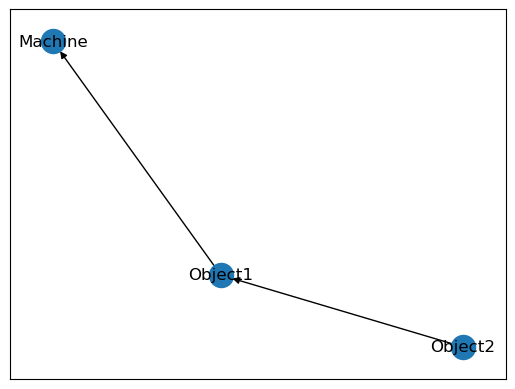





probability of graph: 0.083


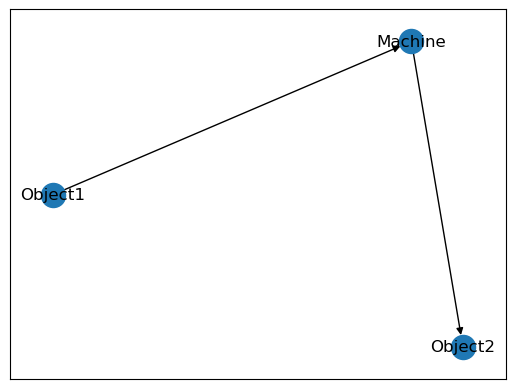





probability of graph: 0.079


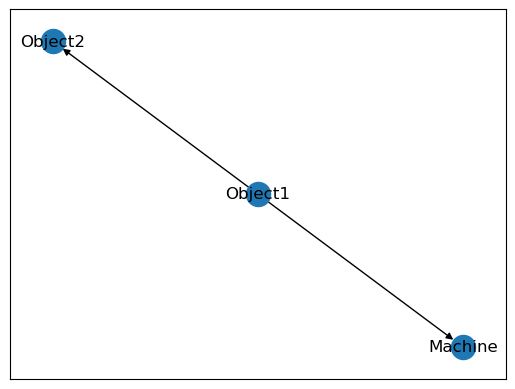





probability of graph: 0.079


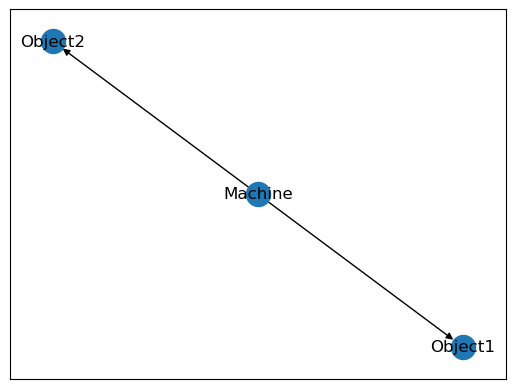





probability of graph: 0.068


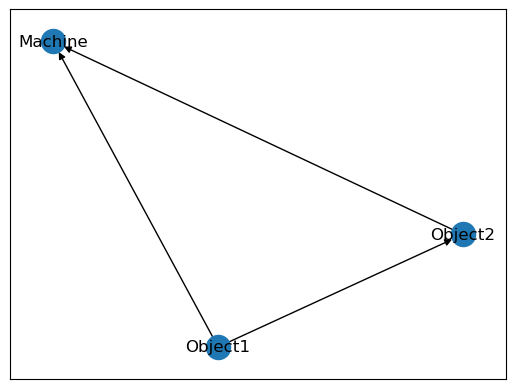





probability of graph: 0.058


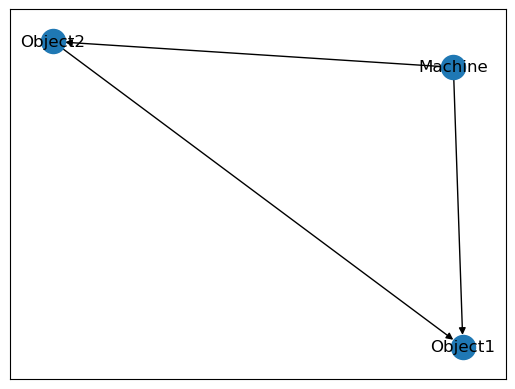





probability of graph: 0.057


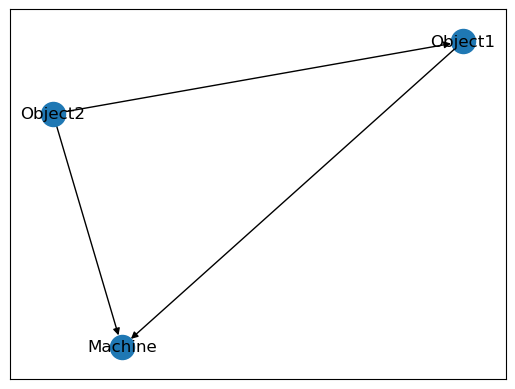





probability of graph: 0.056


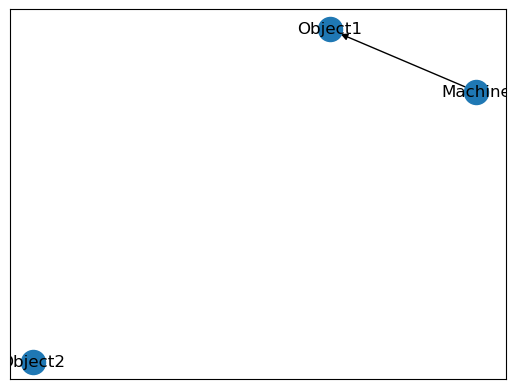

In [57]:
dags, count, graphs = process_posterior("test4/posterior.npy",node_names=["Object1","Object2","Machine"])
graph_posterior(graphs,count)

# DAG-GFlowNet on Tennenbaum and Griffiths 2001

T&G 2001 analyze people's causal inferences based on contingency information. They present a model that predicts with great accuracy people's causal judgments. Can DAG-GFlowNet replicate this?

## NB: This is not really a fair test

The priors are uniform in DAG-GFlowNet, and people's priors are not uniform in the same way. E.g., DAG_GFlownet's prior considers it equally probable that the effect would cause the cause. In the analysis below I collapse both causal models and just consider whether DAG-GFlowNet represents any causal relationship or not. But this is not the best approach (at first I thought it wouldn't matter because they are Markov Equivalent, but I realize it might affect how DAG-GFlowNet samples the posterior).

(Also, T&G use the log odds scale and then do some further non-linear transformations on the output of their model. I don't quite have my mind around why that's justified, but I'll think more about it. Maybe Robert will have a better sense of this?)

Next up I will change the priors. Doing so in their code is non-trivial, but I will work on that next week. 

In [59]:
def create_TG2001_samples(proportion):
    e1c1, e1c0 = proportion
    e0c1, e0c0 = 8-e1c1, 8-e1c0
    samples = pd.DataFrame(np.array([[1,1]]*e1c1 + [[1,0]]*e1c0 + [[0,1]]*e0c1 + [[0,0]]*e0c0), columns=['E','C'])
    samples = format_samples(samples)
    return samples

In [60]:
proportions = [(8, 8), (6, 6), (4, 4), (2, 2), (0, 0), (8, 6), (6, 4), (4, 2), (2, 0), (8, 4), (6, 2), (4, 0), (8, 2), (6, 0), (8, 0)]
samples = [create_TG2001_samples(proportion) for proportion in proportions]

In [109]:
for i, sample in enumerate(samples):
    train_gflownet(model=None,samples=sample, num_iterations=5000,output_folder=f"TGdata/TGdata{i}")

Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 871.03it/s]


No ground truth provided.


Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 971.69it/s]


No ground truth provided.


Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 957.37it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 948.65it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 794.96it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 697.41it/s]


No ground truth provided.


Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 825.62it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 839.74it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 663.01it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 573.96it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 742.01it/s]


No ground truth provided.


Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 661.62it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 648.22it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 681.75it/s]

No ground truth provided.



Sampling from posterior: 100%|██████████| 1000/1000 [00:01<00:00, 612.84it/s]


No ground truth provided.


In [127]:
def prob_causal(dag,count):
    num = count[np.where(np.all(dag == np.array([[0,0],[0,0]]), axis=(1,2)))]
    if len(num) == 0:
        num = 0
    else:
        num = num[0]
    return (1000 - num)/1000
    
def log_odds_causal(dag,count):
    prob = prob_causal(dag,count)
    if prob == 1:
        prob = 0.999
    return np.log(prob/(1-prob))

In [128]:
dags_TG = []
counts_TG = []
graphs_TG = []
probs_causal_TG = []
log_odds_TG = []
for i in range(len(proportions)):
    dag, count, graph = process_posterior(f"TGdata/TGdata{i}/posterior.npy",node_names=["E","C"])
    dags_TG.append(dag)
    counts_TG.append(count)
    graphs_TG.append(graph)
    probs_causal_TG.append(prob_causal(dag,count))
    log_odds_TG.append(log_odds_causal(dag,count))

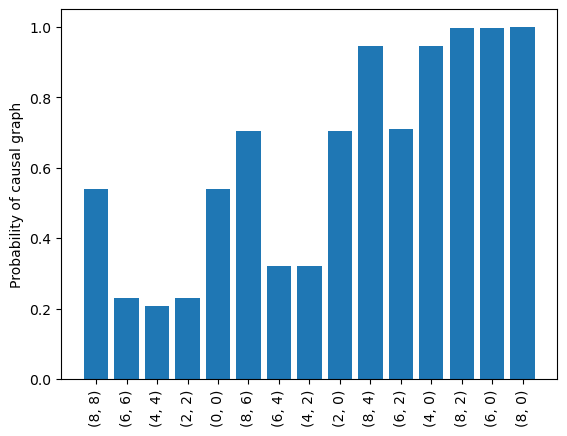

In [144]:
plt.bar(range(len(proportions)),probs_causal_TG)
plt.xticks(range(len(proportions)),proportions,rotation=90)
plt.ylabel("Probability of causal graph")
plt.show()

Human data repprted in T&G:

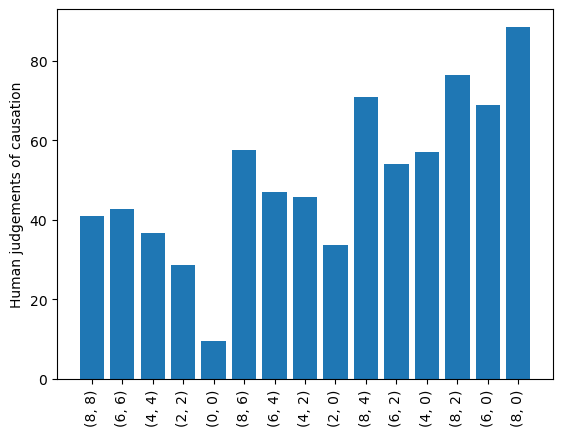

In [145]:
data = [41.10, 42.62, 36.60, 28.62, 9.46, 57.62, 47.06, 45.71, 33.69, 70.85, 54.02, 57.00, 76.54, 69.02, 88.54]
plt.bar(range(len(proportions)),data)
plt.xticks(range(len(proportions)),proportions,rotation=90)
plt.ylabel("Human judgements of causation")
plt.show()


r=0.72,p=0.002


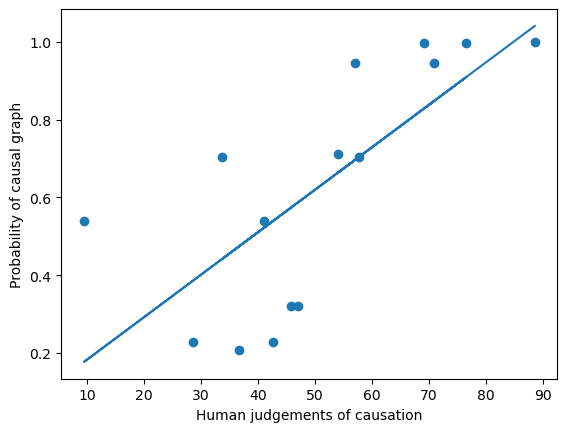

In [146]:
plt.scatter(data,probs_causal_TG)
m, b = np.polyfit(data, probs_causal_TG, 1)
plt.plot(data, m*np.array(data) + b)
plt.xlabel("Human judgements of causation")
plt.ylabel("Probability of causal graph")
from scipy.stats import pearsonr
r, p = pearsonr(data, probs_causal_TG)
print(f"{r=:.2f},{p=:.3f}")